# Data Intern Challenge - Stone

This notebook was created to solve the Conta Stone's data challenge for intern applicants.

The database used for the challenge contains credit card transactional data in 4 tables:

- `customers`
- `cards`
- `transactions`
- `frauds`

It will be used SQL to extract them and Python to analyze it.

The questions/requirements will be explained as we go.

## Imports and database connection

First, some libraries will be imported and the connection with the database will be created.

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
connection = psycopg2.connect(
    database="postgres",
    user="read_only_user",
    password="banking123",
    host="db-stone.cjepwwjnksng.us-east-1.rds.amazonaws.com",
    port='5432'
)

## First exercise

1. Extract and analyze the data in the database in order to answer the following questions. Provide a description and/or comments for each solution.

- What is the average `age` of the customers in the database?

To answer this question, we will first import the `customers` table into a DataFrame, then take a look in its columns.

In [3]:
customers = pd.read_sql("SELECT * FROM CUSTOMERS", connection)
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5674 entries, 0 to 5673
Data columns (total 4 columns):
id               5674 non-null object
age              5674 non-null int64
segment          5674 non-null object
vintage_group    5674 non-null object
dtypes: int64(1), object(3)
memory usage: 177.4+ KB


In [4]:
customers.head()

,id,age,segment,vintage_group
0,CC25034,35,Diamond,VG1
1,CC59625,22,Diamond,VG1
2,CC69314,33,Diamond,VG1
3,CC67036,46,Diamond,VG1
4,CC25597,44,Diamond,VG1


Now that we know its columns, we can calculate the average `age` on this database.

In [5]:
print("The average age of the customers in the database is", np.average(customers.age))

The average age of the customers in the database is 35.059922453295734


It is interesting to see that the average age is lower than the average age of the brazilian entrepreneur, which is 44.7 years old according to SEBRAE (https://datasebrae.com.br/perfil-dos-empresarios/, data from 2016). This may indicate that the Conta Stone public is, in general, younger.

To have a better understanding of the age distribution, we can see the percentiles below:

In [6]:
customers.age.describe()

count    5674.000000
mean       35.059922
std         8.962637
min        20.000000
25%        27.000000
50%        35.000000
75%        43.000000
max        50.000000
Name: age, dtype: float64

The percentiles show that 75% of the dataset has 43 years old or less and the older person has 50, which shows that the public really is younger. One possible explanation for this is that older entrepreneurs still look for the traditional banks instead of going for a more technological and client-oriented one, because they feel safer there.

Obs: alternative query to get the result directly: `SELECT AVG(age) FROM customers`

- How is the `card_family` ranked based on the `credit_limit` given to each card?

For this question, we will analyze the information on the other tables first.

In [7]:
cards = pd.read_sql("SELECT * FROM cards", connection)
transactions = pd.read_sql("SELECT * FROM transactions", connection)
frauds = pd.read_sql("SELECT * FROM frauds", connection)

In [8]:
# Closing the database connection since all tables are already loaded in DataFrames
connection.close()
print("PostgreSQL connection is now closed")

PostgreSQL connection is now closed


In [9]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
card_number     500 non-null object
card_family     500 non-null object
credit_limit    500 non-null int64
customer_id     500 non-null object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
id                  10000 non-null object
card_number         10000 non-null object
transaction_date    10000 non-null object
value               10000 non-null int64
segment             10000 non-null object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


In [11]:
# transaction_date is a date, so we will convert it
transactions['transaction_date'] = pd.to_datetime(transactions.transaction_date)

In [12]:
frauds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
transaction_id    109 non-null object
fraud_flag        109 non-null bool
dtypes: bool(1), object(1)
memory usage: 1.1+ KB


The information that we want is only on the cards table, therefore we will explore this table now:

In [13]:
cards.head()

,card_number,card_family,credit_limit,customer_id
0,8638-5407-3631-8196,Premium,530000,CC67088
1,7106-4239-7093-1515,Gold,18000,CC12076
2,6492-5655-8241-3530,Premium,596000,CC97173
3,2868-5606-5152-5706,Gold,27000,CC55858
4,1438-6906-2509-8219,Platinum,142000,CC90518


In [14]:
cards_grouped_by_family = cards[['card_family', 'credit_limit']].groupby('card_family')

In [15]:
cards_grouped_by_family.describe()

credit_limit                                                    \
                   count           mean            std       min       25%   
card_family                                                                  
Gold               181.0   27878.453039   13495.127921    2000.0   17000.0   
Platinum           112.0  131294.642857   43272.369811   51000.0  101500.0   
Premium            207.0  514763.285024  232013.740397  108000.0  325000.0   

                                           
                  50%       75%       max  
card_family                                
Gold          28000.0   38000.0   50000.0  
Platinum     136500.0  166250.0  200000.0  
Premium      516000.0  710000.0  899000.0

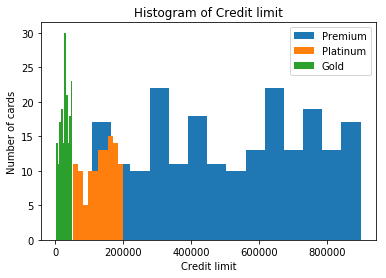

In [16]:
plt.title('Histogram of Credit limit')
plt.xlabel('Credit limit')
plt.ylabel('Number of cards')
plt.hist(cards[cards.card_family == 'Premium']['credit_limit'].values, label='Premium', bins=14)
plt.hist(cards[cards.card_family == 'Platinum']['credit_limit'].values, label='Platinum')
plt.hist(cards[cards.card_family == 'Gold']['credit_limit'].values, label='Gold')
plt.legend(loc='best')
plt.show()

With the plot we can see the `family_card` ranking by `credit_limit`. In general: `Gold < Platinum < Premium`.

For Gold, the maximum value is smaller than the smaller value for Platinum, therefore the division between them is easier to identify. When comparing Platinum and Premium, there is a overlap in a area of the graph, but more than 75% of the Premium cards have greater limit than the maximum Platinum limit. Besides that, the Premium maximum value is way greater than the Platinum, so it presents a wider range of distinct limits.

- For the transactions flagged as fraud, what are the `id`s of the transactions with the highest value?

For this question, we need to join the `transactions` table with the `frauds`.

In [17]:
# Checking if the fraud_flag can be False
frauds.fraud_flag.unique()

array([ True])

In [18]:
fraud_transactions = frauds.merge(transactions, left_on='transaction_id', right_on='id')
fraud_transactions.head()

,transaction_id,fraud_flag,id,card_number,transaction_date,value,segment
0,CTID50558449,True,CTID50558449,4246-1369-3659-8804,2016-05-06,6984,SEG23
1,CTID55936882,True,CTID55936882,1336-9200-1264-2551,2016-11-29,34367,SEG21
2,CTID63762180,True,CTID63762180,8528-6154-7390-5081,2016-12-05,44550,SEG15
3,CTID76723439,True,CTID76723439,7908-2695-7391-7499,2016-09-15,48275,SEG16
4,CTID21246201,True,CTID21246201,2524-4184-5908-6750,2016-02-29,35751,SEG25


In [19]:
highest_value_fraud = fraud_transactions[fraud_transactions.value == fraud_transactions.value.max()]
highest_value_fraud

,transaction_id,fraud_flag,id,card_number,transaction_date,value,segment
6,CTID20567160,True,CTID20567160,3295-6390-4452-7199,2016-10-08,49155,SEG16


In [20]:
print("The transaction id flagged as fraud with the highest value is:", highest_value_fraud['id'].values[0])

The transaction id flagged as fraud with the highest value is: CTID20567160


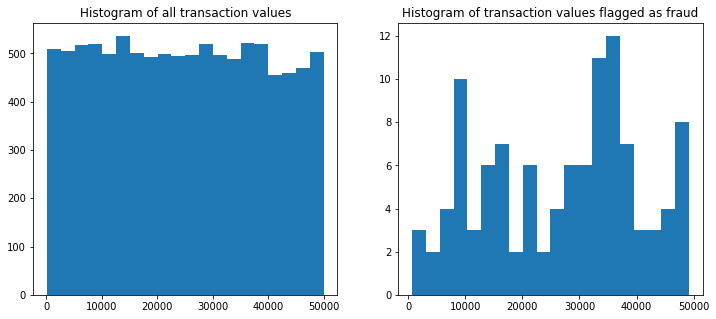

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Histogram of all transaction values')
axs[0].hist(transactions.value, bins=20)
axs[1].set_title('Histogram of transaction values flagged as fraud')
axs[1].hist(fraud_transactions.value, bins=20)
plt.show()

While the transactions value distribution tends to be uniform, the value of flagged transactions is a little more random, with two bigger peaks: one around 10000 and another around 35000.

## Second exercise

2. Analysis:

    - Analyze whether or not the fraudulent transactions are somehow associated to the other features of the dataset. Explain your results.
    
To facilitate the analysis, first, we will get all the important information in the same dataset. The chosen variables (and their origin datasets) are:

- `cards`:
    - `card_family`
    - `credit_limit` (both variables are correlated, but, because of the overlap on Platinum and Premium, it was decided to keep both and pay attention to it)
- `customers`:
    - `age`
    - `segment` (that is equivalent to `vintage_group` as shown in the next cell)
- `transactions`:
    - `transaction_date` (actually, it will be extracted the day, the day of the week and the month to see if these features are important)
    - `value`
    - `segment`
- `frauds`:
    - `fraud_flag`

The ids and numbers will be used just to join the tables since they don't add useful information for the analysis.

In [22]:
# Showing that segment and vintage_group are equivalente in the dataset)
customers.groupby('segment').vintage_group.describe()

,count,unique,top,freq
segment,,,,
Diamond,2524,1,VG1,2524
Gold,1839,1,VG3,1839
Platinum,1311,1,VG2,1311


### Merging tables

In [23]:
transactions_with_fraud_flags = pd.merge(transactions, frauds, left_on='id', right_on='transaction_id', how='left')
# transactions_with_fraud_flags.head()

In [24]:
# Adjusting the added variables before next merge
# The fraud_flag was inputed as True for the transactions in frauds table and NaN for the rest, we will change for False 
transactions_with_fraud_flags['fraud_flag'].fillna(False, inplace=True)
transactions_with_fraud_flags_treated = transactions_with_fraud_flags.drop(columns=['transaction_id'])
# transactions_with_fraud_flags_treated.head()

In [25]:
transaction_with_fraud_and_card = pd.merge(transactions_with_fraud_flags_treated, cards, on='card_number')
# transaction_with_fraud_and_card.head()

In [26]:
transaction_with_fraud_card_and_customers = pd.merge(transaction_with_fraud_and_card, customers, left_on='customer_id', right_on='id', suffixes=['','_customer'])
# transaction_with_fraud_card_and_customers.head()

In [27]:
# Dropping unnecessary variables
transactions_aux = transaction_with_fraud_card_and_customers.drop(columns=['id', 'card_number', 'customer_id', 'id_customer', 'vintage_group'])
# transactions_aux.head()

### Creating the date features

In [28]:
transactions_aux['day'] = transactions_aux.transaction_date.apply(lambda date: date.day)
transactions_aux['weekday'] = transactions_aux.transaction_date.apply(lambda date: date.day_name())
transactions_aux['month'] = transactions_aux.transaction_date.apply(lambda date: date.month)
transactions_analysis = transactions_aux.drop(columns=['transaction_date'])
transactions_analysis.head()

,value,segment,fraud_flag,card_family,credit_limit,age,segment_customer,day,weekday,month
0,23649,SEG25,False,Platinum,194000,23,Gold,24,Sunday,4
1,48307,SEG17,False,Platinum,194000,23,Gold,16,Saturday,1
2,14032,SEG25,False,Platinum,194000,23,Gold,27,Wednesday,4
3,11063,SEG24,False,Platinum,194000,23,Gold,5,Tuesday,7
4,47956,SEG18,False,Platinum,194000,23,Gold,30,Sunday,10


With the variables in the same dataframe and with the date features created, we can take a closer look in each one of them. For this reason, it will be plotted histograms to compare distributions of flagged and not flagged transactions to check for possible relations.

Obs: heights indicate the relative value, not the absolute value (`density=True`)

<Figure size 432x288 with 0 Axes>

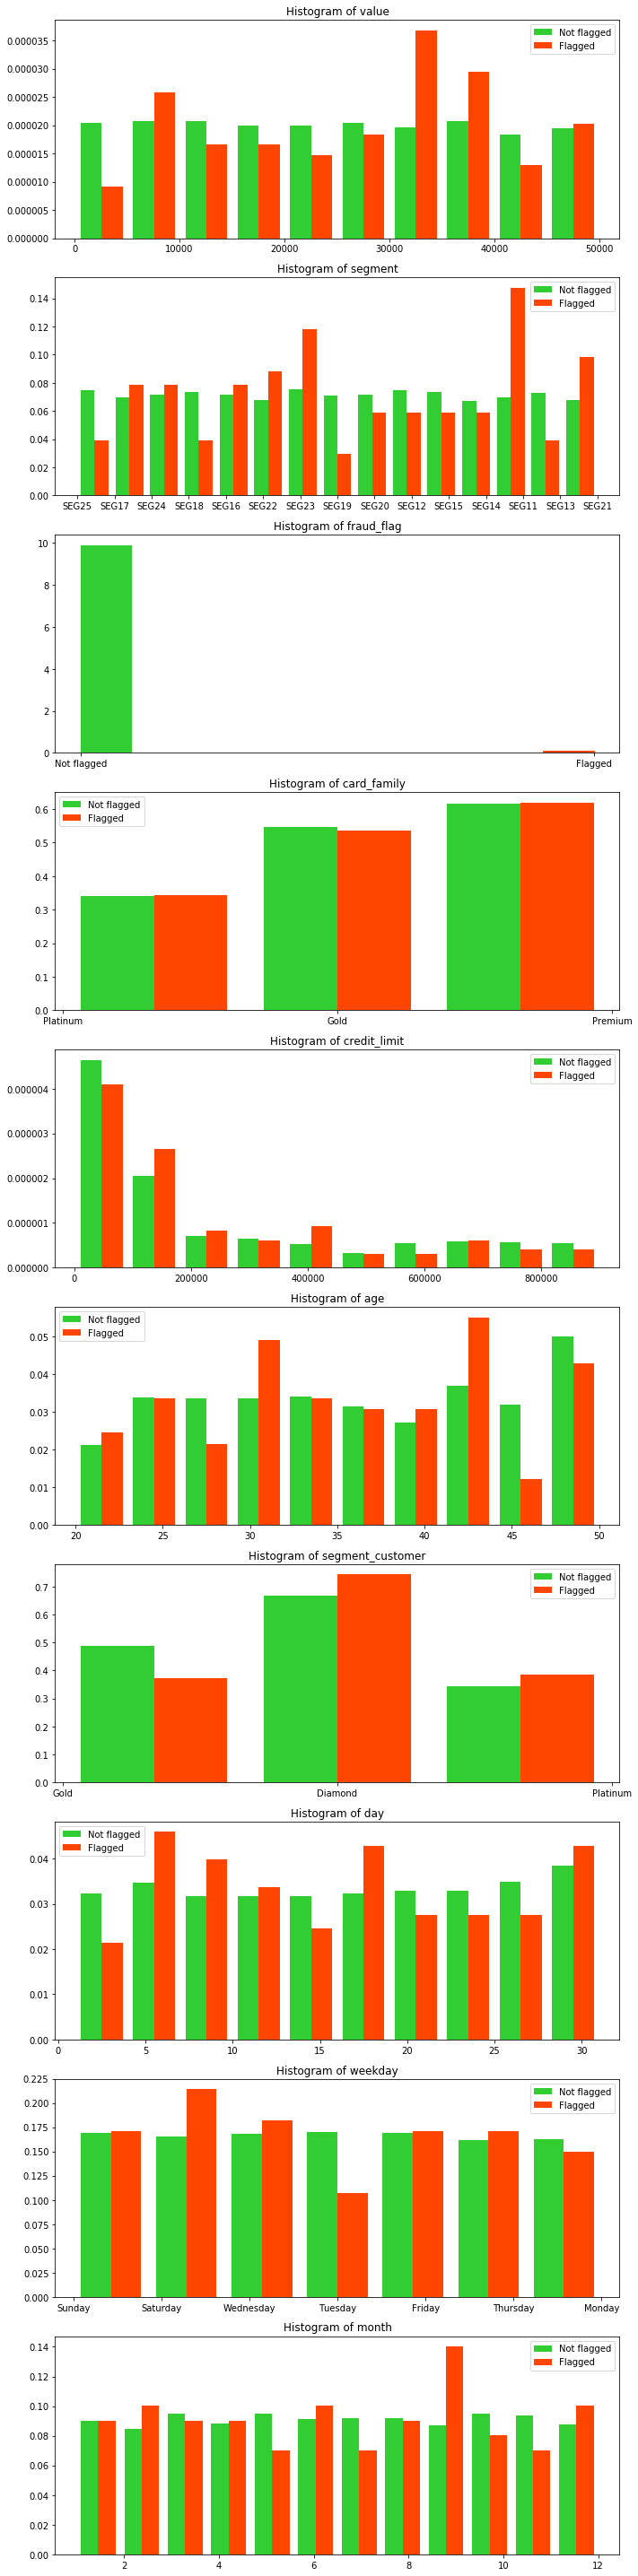

In [29]:
plt.figure()
columns = transactions_analysis.columns
default_bin_size = transactions_analysis.select_dtypes('number').columns.drop('month')
colors = ['limegreen', 'orangered']
rows, cols = len(columns), 1
fig, axs = plt.subplots(rows, cols, figsize=(cols*10, rows*4), squeeze=False)
labels = ['Not flagged', 'Flagged']
i, j = 0, 0
for n in range(len(columns)):
    axs[i, j].set_title('Histogram of %s'%columns[n])
    if columns[n] == 'fraud_flag':
        aux_fraud_hist = transactions_analysis[columns[n]].map({False: 'Not flagged', True: 'Flagged'})
        axs[i, j].hist([aux_fraud_hist], density=True, color=colors[0])
        axs[i, j].patches[-1].set_color(colors[1])
    else:
        if columns[n] in default_bin_size:
            axs[i, j].hist([transactions_analysis[transactions_analysis.fraud_flag == False][columns[n]], transactions_analysis[transactions_analysis.fraud_flag == True][columns[n]]], density=True, label=labels, color=colors)
        else:
            axs[i, j].hist([transactions_analysis[transactions_analysis.fraud_flag == False][columns[n]], transactions_analysis[transactions_analysis.fraud_flag == True][columns[n]]], density=True, label=labels, bins=len(transactions_analysis[columns[n]].unique()), color=colors)
        axs[i, j].legend(loc='best')
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
for n2 in range(n+1, rows*cols):
    fig.delaxes(axs[i, j])
    i, j = (i + 1, 0) if (n2+1) % cols == 0 else (i, j + 1)
fig.tight_layout()
plt.show()

Analyzing histogram by histogram:

- `value`: While the green bars (not flagged as fraud) shows almost an uniform distribution, the red ones (flagged as fraud) doesn't. The latter indicates lower height at the first bar (around half of the green value) and higher at the seventh (around 50% more than the green value). So certain amounts of `value` can have some association with the flag;
- `segment`: Once again the green bars tends to be uniform, but the red ones are far from it. Especially for SEG11 and SEG19, which presents values for flagged transactions around double and half the not flagged ones, respectively. Therefore, the segment may indicate a higher or lower chance of a fraud flag according to its value;
- `fraud_flag`: This histogram just shows how unbalanced the dataset is. We can conclude that noise affects more the Flagged bars because of the fewer number of data, so we need to be more careful with it;
- `card_family`: Both set of bars are really similar, therefore there doesn't seem to be some association with this feature;
- `credit_limit`: The bars are similar. The difference may be caused by the fewer data points on the red data. So it probably doesn't have association either;
- `age`: Around the value 30 and 45 the bars differ a little, but most of the others are similar. Because of this, this variable will be analyzed in another way later;
- `segment_customer`: The small difference between the bars may be caused by the fewer data in this case too, but, to be sure, it will be analyzed later as well
- `day`: Since both distributions recall it other, we will analyze it in another way later;
- `weekday`: Most of days present similar bars, so the difference on Tuesdays and Saturdays are the only ones that may indicate a small correlation with the fraud flag;
- `month`: By the graph, we can notice that September seems an outlier and, since I cannot think of an explanation for this specific month to present a different behaviour, my guess is that, once again, it is just a difference because of the number of data points for fraud flags.

Another way to analyze it is, instead of comparing the bars manually, we can use a feature selection technique to see the importance of each variable and the p-values associated. It gives us a statistical argument to say that some features (or values of features in case of dummified features) are somehow associated with the fraud flag.

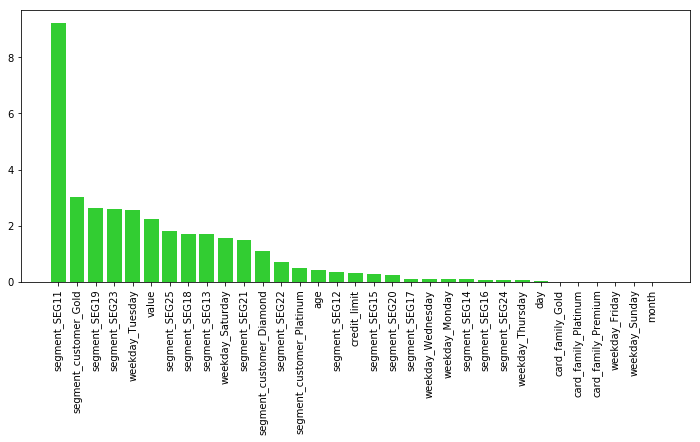

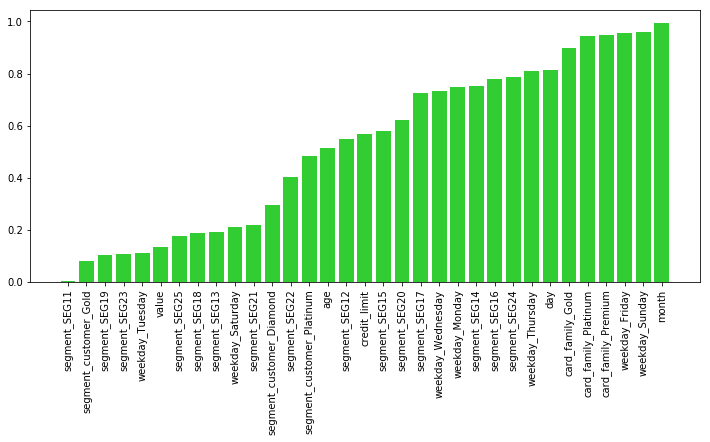

In [30]:
from sklearn.feature_selection import SelectKBest, f_classif

# the categorical features will be dummified first
dataset = pd.get_dummies(transactions_analysis)
y = np.array(dataset.pop('fraud_flag'))
X = np.array(dataset.values)

sel = SelectKBest(f_classif, k='all').fit(X, y)

importance_order = np.argsort((-sel.scores_))

plt.figure(figsize=(12, 5))
plt.bar(dataset.columns[importance_order], sel.scores_[importance_order], color=['limegreen'])
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(dataset.columns[importance_order], sel.pvalues_[importance_order], color=['limegreen'])
plt.xticks(rotation=90)
plt.show()

In [31]:
dataset.columns[sel.pvalues_ < 0.05]

Index(['segment_SEG11'], dtype='object')

In [32]:
dataset.columns[sel.pvalues_ < 0.14]

Index(['value', 'segment_SEG11', 'segment_SEG19', 'segment_SEG23',
       'segment_customer_Gold', 'weekday_Tuesday'],
      dtype='object')

The most statistically significant feature/value is `segment=SEG11`, while the least one is `month` (so September was, most likely, just an outlier). Besides that, we can see that other important ones are: `segment_customer=Gold`, `segment=SEG19`, `segment=SEG23`, `weekday=Tuesday` and `value`.

And for the values that were left for later: `age` may have a small relation to fraud flag, while `day` doesn't seem to have; for `segment_customer`, the value `Gold` has certain importance, so the variable probably has some association with the fraud flag.

### Conclusions for exercise 2:



The `segment` variable has the strongest association with the fraud flag (especially when equal to `SEG11`), but it's not the only one, the others are: `segment_customer`, `weekday` and `value`. While `age` and `credit_limit` are candidates of having a weaker association, however it's hard to be confident about it with only this data.

The other variables doesn't seem to be associated with it.